# Обучение с учителем: качество модели


In [2]:
# Необходимые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report

# дополнительные классы для преобразования данных
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 

RANDOM_STATE = 42
TEST_SIZE = 0.25

d:\projects\DS_10_11\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Загрузка данных

In [3]:
market_file = pd.read_csv("datasets/market_file.csv")  # Коммуникация с клиентом.
market_money = pd.read_csv("datasets/market_money.csv")  # Продуктовое поведение.
market_time = pd.read_csv("datasets/market_time.csv")  # Поведение на сайте.
money = pd.read_csv("datasets/money.csv", sep=";")  # Финансовое поведение.

### 2. Предобработка данных


In [4]:
# Замена запятой на точку для выручки
money['Прибыль'] = pd.to_numeric(
    money['Прибыль'].astype(str).str.replace(',', '.'), 
    errors='coerce'  # Неконвертируемые значения → NaN
)
# предыдцщий_месяц - исправить!
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


In [5]:
# Обзор данных - 1
data_list = [market_file, market_money, market_time, money]
for data in data_list:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
# Обзор данных - 3

for data in data_list:
    print(data.describe())

                  id  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       Акционные_покупки  Средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.0

In [7]:
# Поиск дубликатов
for data in data_list:
    print(data.duplicated().sum())

0
0
0
0


In [8]:
# Поиск пропусков
for data in data_list:
    print(data.isna().sum())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
id         0
Период     0
Выручка    0
dtype: int64
id        0
Период    0
минут     0
dtype: int64
id         0
Прибыль    0
dtype: int64


Пропуски и дубликаты не обнаружены. Типы данных - количественные (int64, float64) и категориальные (object)

In [9]:


# Обзор вариантов полей
display(market_money['Период'].unique())
display(market_time['Период'].unique())
display(market_file['Разрешить сообщать'].unique())


array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

array(['да', 'нет'], dtype=object)

### 3. Исследовательский анализ данных

Шаг 1: Определение активных клиентов (≥3 периода с покупками)
Используем market_money.csv, где есть данные о выручке по периодам.

In [10]:

# Фильтруем записи с ненулевой выручкой и считаем число уникальных периодов на клиента
active_clients = (
    market_money[market_money["Выручка"] > 0]
    .groupby("id")["Период"]
    .nunique()
    .loc[lambda x: x >= 3]
    .index
)
print(f"Клиентов с активностью ≥3 месяцев: {len(active_clients)}")
print(type(active_clients))

Клиентов с активностью ≥3 месяцев: 1297
<class 'pandas.core.indexes.base.Index'>


Шаг 2: Фильтрация всех таблиц по активным клиентам

In [11]:

# Фильтрация
market_file_active = market_file[market_file["id"].isin(active_clients)]
market_money_active = market_money[market_money["id"].isin(active_clients)]
market_time_active = market_time[market_time["id"].isin(active_clients)]
money_active = money[money["id"].isin(active_clients)]
# Список фильтрованных датасетов
filtered_data_list = [market_file_active, market_money_active, market_time_active, money_active]
# Вывод длины каждого фильтрованного датасета  ориентира
print([len(i) for i in filtered_data_list], sep="\n")
print(*[i.head(3) for i in filtered_data_list])

[1297, 3891, 2594, 1297]
       id Покупательская активность Тип сервиса Разрешить сообщать  \
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
1                                   4         

### 4. Объединение таблиц

In [12]:
# Переименовываем столбец 'Период' в каждой таблице - если понадобится их вернуть...
# filtered_data_list[0] = filtered_data_list[0].rename(columns={'Период': 'Период_1'})
# filtered_data_list[1] = filtered_data_list[1].rename(columns={'Период': 'Период_2'})
# filtered_data_list[2] = filtered_data_list[2].rename(columns={'Период': 'Период_3'})

# Удаляем столбец 'Период' из всех таблиц перед объединением
filtered_data_list = [df.drop(columns=['Период'], errors='ignore') for df in filtered_data_list]

# Объединяем первую и вторую таблицы (merge, inner)
df = pd.merge(filtered_data_list[0], filtered_data_list[1], on='id', how='inner')

# Добавляем третью.
df = pd.merge(df, filtered_data_list[2], on='id', how='inner')
# Выводим результат
print(df.head())
display(df.info())

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215349                 Снизилась     премиум                 да   
3  215349                 Снизилась     премиум                 да   
4  215349                 Снизилась     премиум                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.4                     4           819               0.75   
2                 4.4                     4           819               0.75   
3                 4.4                     4           819               0.75   
4                 4.4                     4           819               0.75   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей             

None

#### объединённая таблица по разным периодам

In [13]:
# Создаем пустой DataFrame для новых столбцов
period_columns = pd.DataFrame(index=df['id'].unique())

# Группируем данные по id и периоду
for period in ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']:
    period_data = market_money_active[market_money_active['Период'] == period]
    period_columns[f'Выручка_{period}'] = (
        period_data.set_index('id')['Выручка']
                   .reindex(df['id'].unique(), fill_value=0)  # Заполняем пропуски нулями
    )

# Добавляем новые столбцы в основной DataFrame
df = df.merge(period_columns, left_on='id', right_index=True, how='left')

# Проверяем результат
print(df.columns)
print(df[['id', 'Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']].head())

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка', 'минут', 'Выручка_препредыдущий_месяц',
       'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц'],
      dtype='object')
       id  Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
0  215349                       4472.0                    5216.0   
1  215349                       4472.0                    5216.0   
2  215349                       4472.0                    5216.0   
3  215349                       4472.0                    5216.0   
4  215349                       4472.0                    5216.0   

   Выручка_текущий_месяц  
0                 4971.6  
1                 4971.6  
2                 4971.6  
3            

### 5. Корреляционный анализ

In [14]:
# Сначала отфильтруем столбцы, имеющие числовой тип (int64, float64), исключив ID:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
display(df[numerical_cols].head())
numerical_cols = [col for col in numerical_cols if col != 'id']
numerical_data = df[numerical_cols]
display(numerical_data.columns)

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка,минут,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц
0,215349,4.4,4,819,0.75,4,4,2,5,4472.0,10,4472.0,5216.0,4971.6
1,215349,4.4,4,819,0.75,4,4,2,5,4472.0,12,4472.0,5216.0,4971.6
2,215349,4.4,4,819,0.75,4,4,2,5,4971.6,10,4472.0,5216.0,4971.6
3,215349,4.4,4,819,0.75,4,4,2,5,4971.6,12,4472.0,5216.0,4971.6
4,215349,4.4,4,819,0.75,4,4,2,5,5216.0,10,4472.0,5216.0,4971.6


Index(['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка', 'минут', 'Выручка_препредыдущий_месяц',
       'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц'],
      dtype='object')

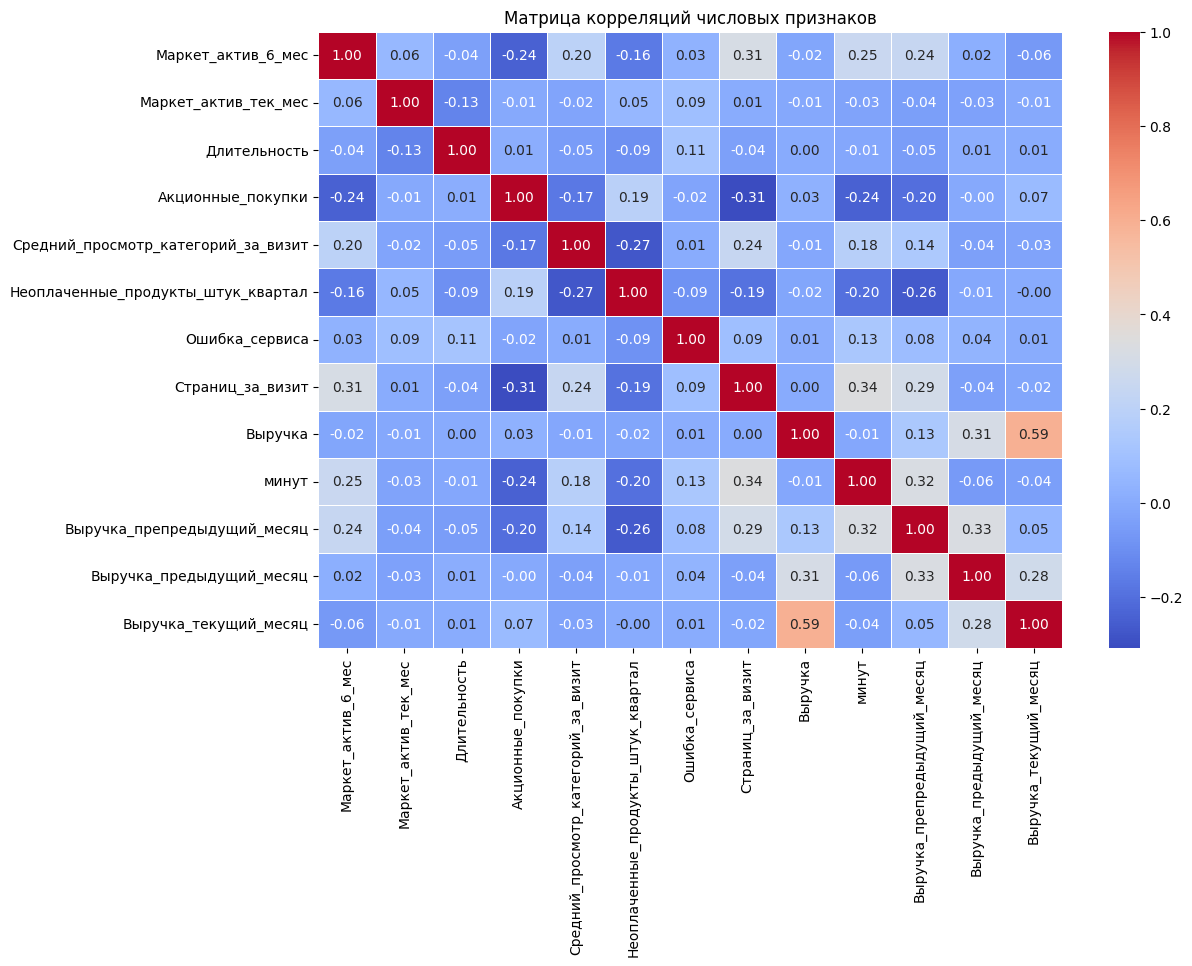

In [15]:

# Построение матрицы корреляций
plt.figure(figsize=(12, 8))
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляций числовых признаков")
plt.show()

Выводы: сильных корреляций нет, но есть слабые корреляции между признаками.
В случае необходимости можно удалить слабые корреляции: 
Страниц_за_визит коррелирует с:

Маркет_актив_6_мес (r=0.31)

Средний_просмотр_категорий_за_визит (r=0.24)

минут (r=0.34)

### 6. Использование пайплайнов

#### 6.1 Подготовка данных


In [16]:

# Делим на числовые и категориальные признаки
print("Числовые признаки:", numerical_cols)  # отобраны на предыдущем этапе

# категориальные признаки
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'id' and col != 'Покупательская активность']
print(categorical_cols)

Числовые признаки: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка', 'минут', 'Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']
['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']


#### 6.2 Добавляем ohe кодирование категориальных данных - создаём пайплайн

In [17]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
    ]
)

Объединяем все признаки в ColumnTransformer

In [18]:

# Разделяем категориальные признаки на 2 группы - для разных скейлеров
ohe_features = ['Тип сервиса', 'Популярная_категория']  # Все категории для OneHotEncoder
ord_features = ['Разрешить сообщать']  # Одна категория для OrdinalEncoder

# Создаем ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_features),  # Используем пайплайн для OneHotEncoder
        ('ord', ord_pipe, ord_features)   # Используем пайплайн для OrdinalEncoder
    ],
    remainder='drop'
)
# Разделяем кколичественные признаки на 2 группы - для разных скейлеров
num_features_group1 = ['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц', 'Длительность']
num_features_group2 = ['Акционные_покупки', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес']

# Создаем ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_features),
        ('num_group2', StandardScaler(), num_features_group2),
        ('num_group1', MinMaxScaler(), num_features_group1)
    ],
    remainder='drop'
)

Итоговый pipeline

In [19]:
# Создаем полный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

# Разделяем данные на признаки и целевую переменную
X = df.drop(columns=['Покупательская активность'])  
y = df['Покупательская активность']

# Преобразуем целевую переменную, если она строковая
if y.dtype == 'object':
    y = y.map({'Снизилась': 0, 'Прежний уровень': 1})

# Разделяем данные на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Обучаем модель
pipe_final.fit(X_train, y_train)

# Оцениваем качество модели
from sklearn.metrics import accuracy_score
y_pred = pipe_final.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(y.value_counts(normalize=True))
print("===================")
print(y.dtype)
print(y.unique())


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       610
           1       1.00      1.00      1.00       947

    accuracy                           1.00      1557
   macro avg       1.00      1.00      1.00      1557
weighted avg       1.00      1.00      1.00      1557

Покупательская активность
1    0.61835
0    0.38165
Name: proportion, dtype: float64
int64
[0 1]


In [20]:
print("Числовые признаки:", numerical_cols)

Числовые признаки: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка', 'минут', 'Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']


In [21]:
print(X_train.head())

          id Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
3519  215937     премиум                 да                 4.1   
5852  216326    стандарт                нет                 3.9   
2576  215780     премиум                 да                 4.1   
3949  216009    стандарт                 да                 3.3   
6549  216442    стандарт                 да                 3.8   

      Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
3519                     5           744               0.16   
5852                     3           219               0.23   
2576                     3           728               0.28   
3949                     4           965               0.21   
6549                     4           907               0.13   

                      Популярная_категория  \
3519                 Косметика и аксесуары   
5852  Мелкая бытовая техника и электроника   
2576                 Косметика и аксесуары   
3949                 Косметика и а

In [22]:
print(df.dtypes)

id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
Выручка                                float64
минут                                    int64
Выручка_препредыдущий_месяц            float64
Выручка_предыдущий_месяц               float64
Выручка_текущий_месяц                  float64
dtype: object


In [23]:
for col in X.columns:
    if len(set(X[col]) & set(y)) > 0:
        print(f"Столбец '{col}' содержит значения, которые также присутствуют в целевой переменной.")

Столбец 'Средний_просмотр_категорий_за_визит' содержит значения, которые также присутствуют в целевой переменной.
Столбец 'Неоплаченные_продукты_штук_квартал' содержит значения, которые также присутствуют в целевой переменной.
Столбец 'Ошибка_сервиса' содержит значения, которые также присутствуют в целевой переменной.
Столбец 'Страниц_за_визит' содержит значения, которые также присутствуют в целевой переменной.


In [24]:
# Проверяем, есть ли общие строки между обучающей и тестовой выборками
common_rows = np.intersect1d(X_train.index, X_test.index)
if len(common_rows) > 0:
    print("Обнаружено пересечение строк между обучающей и тестовой выборками:")
    print(common_rows)
else:
    print("Обучающая и тестовая выборки не пересекаются.")

Обучающая и тестовая выборки не пересекаются.


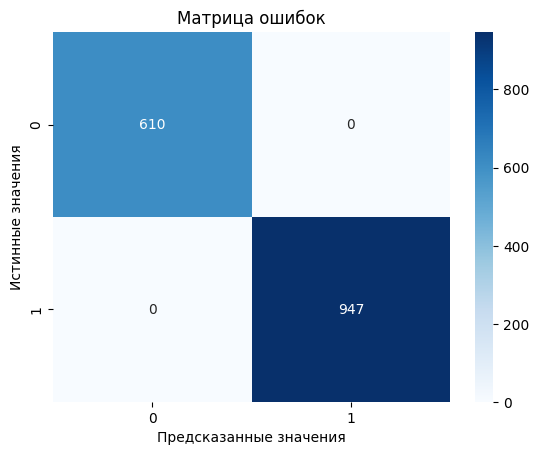

In [25]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.title("Матрица ошибок")
plt.show()

!Не забыть - интерпретация матрицы ошибок. Почему accuracy 1.0? - слишком много, но пересечений нет, целевой в обучающий не попал..

#### 6.2 Обучаем модели

In [26]:
# К ближайших соседей

# Пайплайн с KNeighborsClassifier
knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

# Гиперпараметры для подбора
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance']
}

# Подбор гиперпараметров
grid_search_knn = GridSearchCV(
    knn_pipe,
    param_grid_knn,
    cv=5,
    scoring='accuracy'
)
grid_search_knn.fit(X_train, y_train)

print("Лучшие параметры для KNeighborsClassifier:", grid_search_knn.best_params_)
print("Лучшая точность:", grid_search_knn.best_score_)

Лучшие параметры для KNeighborsClassifier: {'model__n_neighbors': 7, 'model__weights': 'distance'}
Лучшая точность: 0.9988755020080321


In [27]:
# Пайплайн с DecisionTreeClassifier
dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Гиперпараметры для подбора
param_grid_dt = {
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10]
}

# Подбор гиперпараметров
grid_search_dt = GridSearchCV(
    dt_pipe,
    param_grid_dt,
    cv=5,
    scoring='accuracy'
)
grid_search_dt.fit(X_train, y_train)

print("Лучшие параметры для DecisionTreeClassifier:", grid_search_dt.best_params_)
print("Лучшая точность:", grid_search_dt.best_score_)

Лучшие параметры для DecisionTreeClassifier: {'model__max_depth': None, 'model__min_samples_split': 2}
Лучшая точность: 0.9985542168674698


In [28]:
# Пайплайн с LogisticRegression
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Гиперпараметры для подбора
param_grid_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__solver': ['lbfgs', 'liblinear']
}

# Подбор гиперпараметров
grid_search_lr = GridSearchCV(
    lr_pipe,
    param_grid_lr,
    cv=5,
    scoring='accuracy'
)
grid_search_lr.fit(X_train, y_train)

print("Лучшие параметры для LogisticRegression:", grid_search_lr.best_params_)
print("Лучшая точность:", grid_search_lr.best_score_)

Лучшие параметры для LogisticRegression: {'model__C': 10.0, 'model__solver': 'lbfgs'}
Лучшая точность: 0.816706827309237


In [29]:
# Пайплайн с SVC
svc_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(random_state=42))
])

# Гиперпараметры для подбора
param_grid_svc = {
    'model__C': [0.1, 1.0, 10.0],
    'model__kernel': ['linear', 'rbf']
}

# Подбор гиперпараметров
grid_search_svc = GridSearchCV(
    svc_pipe,
    param_grid_svc,
    cv=5,
    scoring='accuracy'
)
grid_search_svc.fit(X_train, y_train)

print("Лучшие параметры для SVC:", grid_search_svc.best_params_)
print("Лучшая точность:", grid_search_svc.best_score_)

Лучшие параметры для SVC: {'model__C': 10.0, 'model__kernel': 'rbf'}
Лучшая точность: 0.8719678714859438


#### Выбор лучшей модели

In [30]:
models = {
    "KNeighborsClassifier": grid_search_knn,
    "DecisionTreeClassifier": grid_search_dt,
    "LogisticRegression": grid_search_lr,
    "SVC": grid_search_svc
}

best_model = None
best_accuracy = -1

for name, model in models.items():
    accuracy = model.best_score_
    print(f"{name}: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print("Лучшая модель:", best_model)
print("Точность:", best_accuracy)

KNeighborsClassifier: 0.9988755020080321
DecisionTreeClassifier: 0.9985542168674698
LogisticRegression: 0.816706827309237
SVC: 0.8719678714859438
Лучшая модель: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Тип '
                                                                          'сервиса',
                                                                          'Популярная_категория']),
                                                                      

Проверяем качество модели на тестовых данных:


In [31]:
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {test_accuracy}")

Точность на тестовой выборке: 1.0


### 7. Анализ важности признаков
Используем метод SHAP, построим график важности.

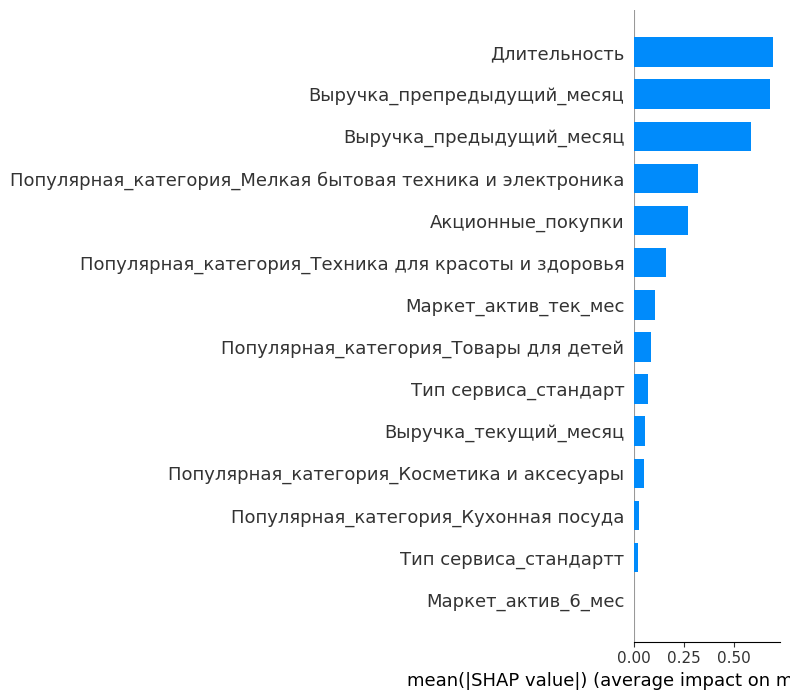

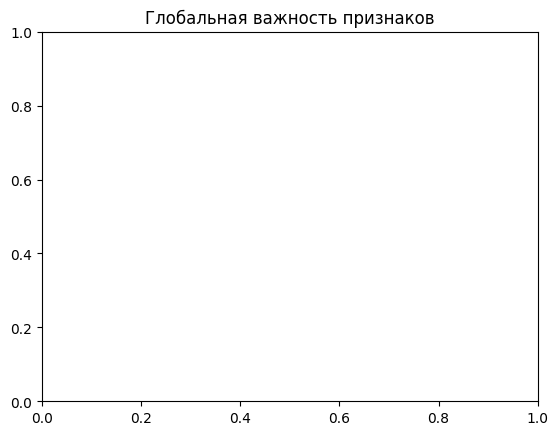

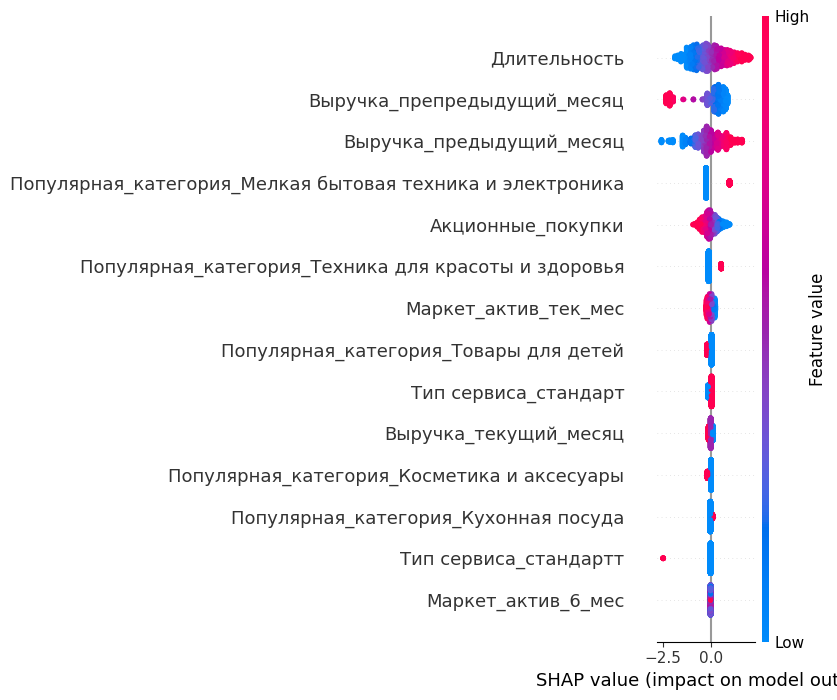

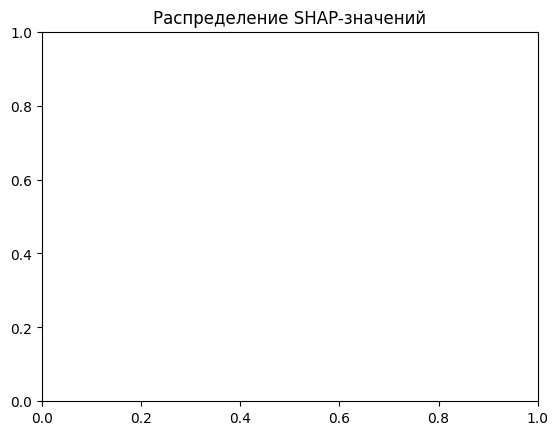

In [32]:
# Получаем лучшую модель из GridSearchCV
final_model = grid_search_lr.best_estimator_

# Проверяем, является ли модель пайплайном
if isinstance(final_model, Pipeline):
    # Получаем шаг с моделью
    model_step = final_model.named_steps['model']
    
    # Получаем предобработанные данные для объяснения
    preprocessor = final_model.named_steps['preprocessor']
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Создаем список для хранения имен признаков после преобразования
    feature_names = []
    
    # Обработка OneHotEncoder
    if 'ohe' in preprocessor.named_transformers_:
        ohe = preprocessor.named_transformers_['ohe'].named_steps['ohe']  # Получаем OneHotEncoder
        ohe_features = preprocessor.named_transformers_['ohe'].get_feature_names_out()  # Имена исходных признаков
        feature_names.extend(ohe_features)
    
    # Обработка числовых признаков
    if 'num_group1' in preprocessor.named_transformers_:
        num_features_group1 = preprocessor.named_transformers_['num_group1'].get_feature_names_out()
        feature_names.extend(num_features_group1)
    
    if 'num_group2' in preprocessor.named_transformers_:
        num_features_group2 = preprocessor.named_transformers_['num_group2'].get_feature_names_out()
        feature_names.extend(num_features_group2)
    
    # Создаем DataFrame с именами признаков
    X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
    
    # Создаем объяснитель SHAP для линейной модели
    explainer = shap.LinearExplainer(model_step, X_train_transformed_df)
    
    # Вычисляем SHAP-значения для тестовых данных
    shap_values = explainer.shap_values(X_test_transformed_df)
    
    # Для бинарной классификации берем SHAP values для класса 1
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # Визуализация: Глобальная важность признаков
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")
    plt.title("Глобальная важность признаков")
    plt.show()
    
    # Визуализация: Распределение SHAP-значений
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_transformed_df)
    plt.title("Распределение SHAP-значений")
    plt.show()
else:
    print("Модель не является пайплайном, требуется другая обработка")

### 8. Сегментация покупателей.

In [33]:
# Предсказания модели (классы)
y_pred = best_model.predict(X)

# Вероятности классов (если нужно)
y_proba = best_model.predict_proba(X)[:, 1]  # Вероятность класса "снизилась"
# Добавляем предсказания в исходные данные
df['Уровень_активности'] = y_pred
df['Вероятность_снижения'] = y_proba

print(df.head())

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215349                 Снизилась     премиум                 да   
3  215349                 Снизилась     премиум                 да   
4  215349                 Снизилась     премиум                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.4                     4           819               0.75   
2                 4.4                     4           819               0.75   
3                 4.4                     4           819               0.75   
4                 4.4                     4           819               0.75   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей             

In [34]:
# Группировка данных по уровню активности
group_analysis = df.groupby('Уровень_активности').agg({
    'Выручка_текущий_месяц': 'mean',
    'Маркет_актив_тек_мес': 'mean',
    'id': 'count'
}).rename(columns={'id': 'Count'})

print(group_analysis)

                    Выручка_текущий_месяц  Маркет_актив_тек_мес  Count
Уровень_активности                                                    
0                             5508.840404              4.006061   2970
1                             5197.704115              4.011222   4812


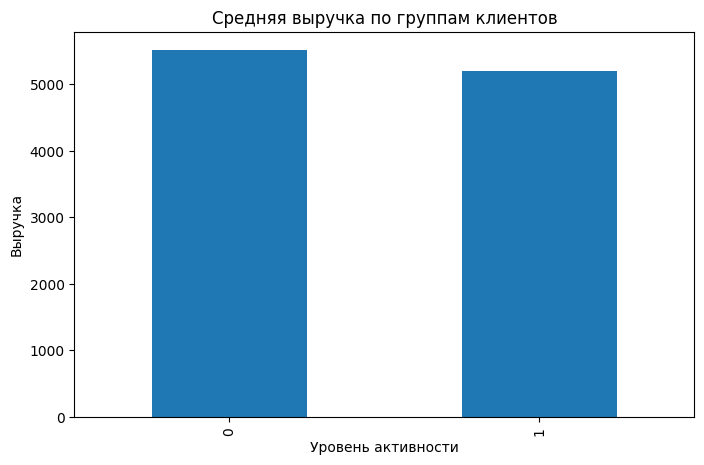

In [35]:
# График средней выручки по группам
group_analysis['Выручка_текущий_месяц'].plot(kind='bar', figsize=(8, 5))
plt.title('Средняя выручка по группам клиентов')
plt.xlabel('Уровень активности')
plt.ylabel('Выручка')
plt.show()

In [36]:
# Группировка по уровню активности и любимой категории
category_analysis = (
    df.groupby(['Уровень_активности', 'Популярная_категория'])
      .size()
      .reset_index(name='Count')
)

print(category_analysis)

    Уровень_активности                  Популярная_категория  Count
0                    0                     Домашний текстиль    606
1                    0                 Косметика и аксесуары    630
2                    0                       Кухонная посуда    396
3                    0  Мелкая бытовая техника и электроника    162
4                    0        Техника для красоты и здоровья    306
5                    0                      Товары для детей    870
6                    1                     Домашний текстиль    894
7                    1                 Косметика и аксесуары    708
8                    1                       Кухонная посуда    432
9                    1  Мелкая бытовая техника и электроника    882
10                   1        Техника для красоты и здоровья    792
11                   1                      Товары для детей   1104


In [37]:
# Выбираем категорию
selected_category = 'Мелкая бытовая техника и электроника'

# Фильтруем данные по выбранной категории
category_data = df[df['Популярная_категория'] == selected_category]


category_data = category_data.drop(columns=['id'])

# Применяем модель
category_data['Уровень_активности'] = best_model.predict(category_data)
category_data['Вероятность_снижения'] = best_model.predict_proba(category_data)[:, 1]


print(category_data.head())

    Покупательская активность Тип сервиса Разрешить сообщать  \
282                 Снизилась     премиум                 да   
283                 Снизилась     премиум                 да   
284                 Снизилась     премиум                 да   
285                 Снизилась     премиум                 да   
286                 Снизилась     премиум                 да   

     Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
282                 3.5                     5           882   
283                 3.5                     5           882   
284                 3.5                     5           882   
285                 3.5                     5           882   
286                 3.5                     5           882   

     Акционные_покупки                  Популярная_категория  \
282               0.22  Мелкая бытовая техника и электроника   
283               0.22  Мелкая бытовая техника и электроника   
284               0.22  Мелкая бытовая техни

In [38]:
# Добавляем вероятности снижения активности в исходные данные
df['Вероятность_снижения'] = best_model.predict_proba(df.drop(columns=['id']))[:, 1]

# Группируем данные по категории и анализируем среднюю вероятность снижения
category_risk = df.groupby('Популярная_категория')['Вероятность_снижения'].mean().reset_index()

print(category_risk)

                   Популярная_категория  Вероятность_снижения
0                     Домашний текстиль              0.596000
1                 Косметика и аксесуары              0.529148
2                       Кухонная посуда              0.521739
3  Мелкая бытовая техника и электроника              0.844828
4        Техника для красоты и здоровья              0.721311
5                      Товары для детей              0.559271
